# Validate Dynast's metabolic labeling quantification

This notebook will validate the metabolic labeling quantification (labeled, unlabeled transcripts) produced by Dynast with that produced by the [scNT-seq pipeline](https://github.com/wulabupenn/scNT-seq). Note that several changes were necessary to the scNT-seq pipeline due to inherent bugs and outdated dependencies. The version used for this study can be found [here](https://github.com/Lioscro/scNT-seq).

In [134]:
import warnings
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    import dynamo as dyn
    
import anndata
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sns
from sklearn.metrics import r2_score

plt.style.use('default')
plt.style.use('../figures.mplstyle')
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

## Load the data

In [76]:
with open('data/accessions.txt', 'r') as f:
    accessions = [line.strip() for line in f]
sample_accessions = accessions[1:]

gene_list = pd.read_csv('data/0408_grp_info.txt', sep='\t')
# Some genes have been renamed in this reference.
gene_list.rename({
    'Gltscr2': 'Nop53',
    'A830010M20Rik': 'Btbd8'
}, inplace=True)

cell_list = pd.read_csv('data/cells.csv', names=['time', 'barcode'])

accession_times = {
    'SRR11683967': 0,
    'SRR11683968': 15,
    'SRR11683969': 30,
    'SRR11683970': 60,
    'SRR11683971': 120
}
dynast_adatas = {}
scNT_adatas = {}
for accession in sample_accessions:
    scNT_adata = anndata.read(f'scNT/{accession}/adata/adata.h5ad')
    dynast_adata = anndata.read(f'dynast/{accession}/count/adata.h5ad')
    
    # Make sure both have the same cells and genes
    barcodes = np.intersect1d(scNT_adata.obs_names, dynast_adata.obs_names)
    barcodes = sorted(np.intersect1d(barcodes, cell_list[cell_list['time'] == accession_times[accession]]['barcode']))
    genes = sorted(np.intersect1d(scNT_adata.var_names, dynast_adata.var_names))

    scNT_adatas[accession] = scNT_adata[barcodes, genes].copy()
    dynast_adatas[accession] = dynast_adata[barcodes, genes].copy()

## Comparisons

Compare the labeled, unlabeled counts between the two pipelines.

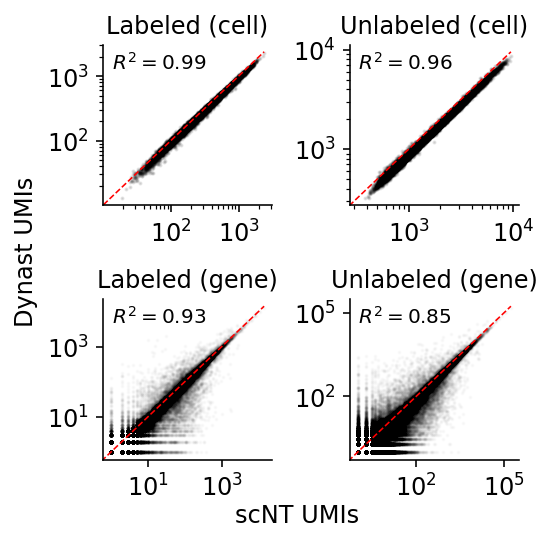

In [152]:
def plot_correlation(x, y, alpha, ax):
    r2 = r2_score(np.log1p(x), np.log1p(y))
    
    ax.scatter(x, y, s=1, c='black', alpha=alpha)
    high = max(max(x), max(y))
    ax.plot([0, high], [0, high], c='red', linestyle='--', linewidth=0.8)
    ax.text(0.05, 0.85, f'$R^2 = {r2:.2f}$', fontsize=10, transform=ax.transAxes)
    ax.set_xscale('log')
    ax.set_yscale('log')
    
    xlow, xhigh = ax.get_xlim()
    ylow, yhigh = ax.get_ylim()
    lim_low = min(xlow, ylow)
    lim_high = max(xhigh, yhigh)
    ax.set_xlim(lim_low, lim_high)
    ax.set_ylim(lim_low, lim_high)

scNT_cell_labeled = []
scNT_cell_unlabeled = []
dynast_cell_labeled = []
dynast_cell_unlabeled = []

scNT_gene_labeled = []
scNT_gene_unlabeled = []
dynast_gene_labeled = []
dynast_gene_unlabeled = []
for accession in sample_accessions:
    scNT_adata = scNT_adatas[accession]
    dynast_adata = dynast_adatas[accession]
    
    scNT_cell_labeled.extend(scNT_adata.layers['labeled_TC'].sum(axis=1).A.flatten())
    dynast_cell_labeled.extend(dynast_adata.layers['X_l_TC'].sum(axis=1).A.flatten())
    
    scNT_cell_unlabeled.extend(scNT_adata.layers['unlabeled_TC'].sum(axis=1).A.flatten())
    dynast_cell_unlabeled.extend(dynast_adata.layers['X_n_TC'].sum(axis=1).A.flatten())
    
    scNT_gene_labeled.extend(scNT_adata.layers['labeled_TC'].sum(axis=0).A.flatten())
    dynast_gene_labeled.extend(dynast_adata.layers['X_l_TC'].sum(axis=0).A.flatten())
    
    scNT_gene_unlabeled.extend(scNT_adata.layers['unlabeled_TC'].sum(axis=0).A.flatten())
    dynast_gene_unlabeled.extend(dynast_adata.layers['X_n_TC'].sum(axis=0).A.flatten())
    
fig, axes = plt.subplots(figsize=(4, 4), ncols=2, nrows=2, tight_layout=True)
plot_correlation(scNT_cell_labeled, dynast_cell_labeled, 0.1, axes[0,0])
axes[0, 0].set_title('Labeled (cell)')

plot_correlation(scNT_cell_unlabeled, dynast_cell_unlabeled, 0.1, axes[0,1])
axes[0, 1].set_title('Unlabeled (cell)')

plot_correlation(scNT_gene_labeled, dynast_gene_labeled, 0.02, axes[1,0])
axes[1, 0].set_title('Labeled (gene)')
axes[1, 0].set_xticks([10, 1000])

plot_correlation(scNT_gene_unlabeled, dynast_gene_unlabeled, 0.02, axes[1,1])
axes[1, 1].set_title('Unlabeled (gene)')
axes[1, 1].set_xticks([100, 100000])

fig.supylabel('Dynast UMIs', x=0.06, y=0.55)
fig.supxlabel('scNT UMIs', y=0.07, x=0.55)

fig.savefig('figures/scNT_umis.png', bbox_inches='tight', dpi=300)

NTR correlation

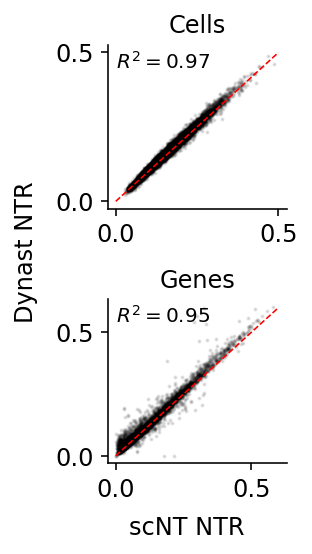

In [153]:
def plot_ntr_correlation(x, y, high, ax):
    r2 = r2_score(x, y)
    
    ax.scatter(x, y, s=1, c='black', alpha=0.1)
    ax.plot([0, high], [0, high], c='red', linestyle='--', linewidth=0.8)
    ax.set_xticks([0.0, 0.5])
    ax.set_yticks([0.0, 0.5])
    ax.text(0, ax.get_ylim()[1] * 0.85, f'$R^2 = {r2:.2f}$', fontsize=10)

scNT_cell_ntrs = []
dynast_cell_ntrs = []
scNT_gene_ntrs = []
dynast_gene_ntrs = []

for accession in sample_accessions:
    scNT_adata = scNT_adatas[accession].copy()
    dynast_adata = dynast_adatas[accession].copy()
    
    scNT_cell_ntr = scNT_adata.layers['labeled_TC'].sum(axis=1).A.flatten() / scNT_adata.X.sum(axis=1).A.flatten()
    dynast_cell_ntr = dynast_adata.layers['X_l_TC'].sum(axis=1).A.flatten() / dynast_adata.X.sum(axis=1).A.flatten()
    scNT_cell_ntrs.extend(scNT_cell_ntr)
    dynast_cell_ntrs.extend(dynast_cell_ntr)
    
    genes = scNT_adata.X.sum(axis=0).A.flatten().argsort()[-1000:]
    scNT_adata = scNT_adata[:, genes].copy()
    dynast_adata = dynast_adata[:, genes].copy()
    
    scNT_gene_sum = scNT_adata.X.sum(axis=0).A.flatten()
    dynast_gene_sum = dynast_adata.X.sum(axis=0).A.flatten()
    gene_mask = (scNT_gene_sum > 0) & (dynast_gene_sum > 0)
    scNT_adata = scNT_adata[:,gene_mask].copy()
    dynast_adata = dynast_adata[:, gene_mask].copy()
    
    scNT_gene_ntr = scNT_adata.layers['labeled_TC'].sum(axis=0).A.flatten() / scNT_adata.X.sum(axis=0).A.flatten()
    dynast_gene_ntr = dynast_adata.layers['X_l_TC'].sum(axis=0).A.flatten() / dynast_adata.X.sum(axis=0).A.flatten()
    
    scNT_gene_ntrs.extend(scNT_gene_ntr)
    dynast_gene_ntrs.extend(dynast_gene_ntr)

fig, axes = plt.subplots(figsize=(2.3, 4), nrows=2, tight_layout=True)
plot_ntr_correlation(scNT_cell_ntrs, dynast_cell_ntrs, 0.5, axes[0])
axes[0].set_title('Cells')
plot_ntr_correlation(scNT_gene_ntrs, dynast_gene_ntrs, 0.6, axes[1])
axes[1].set_title('Genes')

fig.supxlabel('scNT NTR', y=0.05, x=0.6)
fig.supylabel('Dynast NTR', x=0.08, y=0.55)

fig.savefig('figures/scNT_ntr.png', bbox_inches='tight', dpi=300)

## RNA velocity

Generate RNA velocity flows similar to that was done in the scNT-seq paper [Figure 3](https://www.nature.com/articles/s41592-020-0935-4/figures/3).

We will use a subset of neural activity genes (identified in [Extended Data Fig. 2.d](https://www.nature.com/articles/s41592-020-0935-4/figures/8)).

In [133]:
scNT_adata = anndata.AnnData.concatenate(
    *list(scNT_adatas.values()), batch_key='accession', batch_categories=scNT_adatas.keys()
)
dynast_adata = anndata.AnnData.concatenate(
    *list(dynast_adatas.values()), batch_key='accession', batch_categories=dynast_adatas.keys()
)

# Activation time, as a category for better colors
scNT_adata.obs['activation_time'] = scNT_adata.obs['accession'].map(accession_times).astype('category')
dynast_adata.obs['activation_time'] = dynast_adata.obs['accession'].map(accession_times).astype('category')

# Labeling time in hours
scNT_adata.obs['labeling_time'] = 2
dynast_adata.obs['labeling_time'] = 2

# Rename layers for Dynamo
scNT_adata.layers['new'] = scNT_adata.layers['labeled_TC'].copy()
scNT_adata.layers['total'] = scNT_adata.X.copy()
for layer in list(scNT_adata.layers.keys()):
    if layer not in ('new', 'total'):
        del scNT_adata.layers[layer]
dynast_adata.layers['new'] = dynast_adata.layers['X_l_TC'].copy()
dynast_adata.layers['total'] = dynast_adata.X.copy()
for layer in list(dynast_adata.layers.keys()):
    if layer not in ('new', 'total'):
        del dynast_adata.layers[layer]
        
scNT_adata.write('scNT/adata.h5ad', compression='gzip')
dynast_adata.write('dynast/adata.h5ad', compression='gzip')
        
# Subset genes
# scNT_adata = scNT_adata[:, gene_list.index].copy()
# dynast_adata = dynast_adata[:, gene_list.index].copy()

# def dynamo_workflow(adata):
#     adata = dyn.pp.recipe_monocle(adata.copy())
#     dyn.tl.dynamics(adata)
#     dyn.tl.reduceDimension(adata)
#     dyn.tl.cell_velocities(adata, calc_rnd_vel=True)
#     dyn.vf.VectorField(adata, basis='umap')
    
# dynamo_workflow(scNT_adata)
# dynamo_workflow(dynast_adata)

In [8]:
scNT_adata = dyn.pp.recipe_monocle(scNT_adata)

/home/kmin/miniconda3/lib/python3.8/site-packages/dynamo/preprocessing/preprocess.py:1374: UserWarning: only 97 genes passed basic filtering, but you requested 2000 genes for feature selection. Try lowering the gene selection stringency: {'min_expr_cells': 0, 'min_expr_avg': 0, 'max_expr_avg': inf, 'svr_gamma': None, 'winsorize': False, 'winsor_perc': (1, 99.5), 'sort_inverse': False}
  warnings.warn(f'only {pass_basic_filter_num} genes passed basic filtering, but you requested {n_top_genes} '


KeyError: 'X'

In [136]:
scNT_adata.obs

,accession,activation_time,labeling_time
AAAAAAACGTAT-SRR11683967,SRR11683967,0,2
AAAAACCCCGAT-SRR11683967,SRR11683967,0,2
AAAACATCATGA-SRR11683967,SRR11683967,0,2
AAAAGAACCTGA-SRR11683967,SRR11683967,0,2
AAAAGCATTATT-SRR11683967,SRR11683967,0,2
...,...,...,...
TTTTTCGTGTCA-SRR11683971,SRR11683971,120,2
TTTTTCTCATGA-SRR11683971,SRR11683971,120,2
TTTTTGTAGAAT-SRR11683971,SRR11683971,120,2
TTTTTGTATAGT-SRR11683971,SRR11683971,120,2


In [15]:
dyn.tl.dynamics(scNT_adata, NTR_vel=True)

|-----> dynamics_del_2nd_moments_key is None. Using default value from DynamoAdataConfig: dynamics_del_2nd_moments_key=False
|-----------> removing existing M layers:[]...
|-----------> making adata smooth...
|-----> calculating first/second moments...
|-----> [moments calculation] in progress: 100.0000%
|-----> [moments calculation] finished [82.3637s]
|-----> experiment type: deg, method: direct, model: deterministic


/home/kmin/miniconda3/lib/python3.8/site-packages/dynamo/tools/moments.py:664: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  sfs, tot_sfs = sfs[:, None], sfs[:, None]
estimating kinetic-parameters using kinetic model:   0%|                                                              | 0/97 [00:00<?, ?it/s]/home/kmin/miniconda3/lib/python3.8/site-packages/dynamo/estimation/tsc/estimation_kinetic.py:355: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  x0_bound = np.array([0, 1e2 * x0])
estimating kinetic-parameters using kinetic model: 100%|█████████████████████████████████████████████████████| 97/97 [00:01<00:00, 64.40it/s]


AnnData object with n_obs × n_vars = 20925 × 24204
    obs: 'accession', 'activation_time', 'labeling_time', 'nGenes', 'nCounts', 'pMito', 'pass_basic_filter', 'total_Size_Factor', 'initial_total_cell_size', 'Size_Factor', 'initial_cell_size', 'new_Size_Factor', 'initial_new_cell_size', 'ntr'
    var: 'nCells', 'nCounts', 'pass_basic_filter', 'use_for_pca', 'frac', 'ntr', 'alpha', 'a', 'b', 'alpha_a', 'alpha_i', 'beta', 'p_half_life', 'gamma', 'half_life', 'cost', 'logLL', 'use_for_dynamics'
    uns: 'pp', 'PCs', 'explained_variance_ratio_', 'pca_mean', 'pca_fit', 'feature_selection', 'dynamics'
    obsm: 'X_pca', 'X'
    layers: 'new', 'total', 'X_total', 'X_new', 'M_t', 'M_tt', 'M_n', 'M_tn', 'M_nn'
    obsp: 'moments_con'

In [16]:
dyn.tl.reduceDimension(scNT_adata)

|-----> retrive data for non-linear dimension reduction...
|-----> perform umap...
|-----> [dimension_reduction projection] in progress: 100.0000%
|-----> [dimension_reduction projection] finished [68.6136s]


In [26]:
dyn.tl.cell_velocities(scNT_adata, calc_rnd_vel=True)

|-----? A new set of transition genes is used, but because enforce=False, the transition matrix might not be recalculated if it is found in .obsp.


AttributeError: 'NoneType' object has no attribute 'shape'

In [23]:
scNT_adata.var['use_for_dynamics'].sum()

97

In [12]:
neu_adata = anndata.read('data/Neu_one_shot.h5ad')

In [13]:
neu_adata.shape

(18133, 37661)

In [14]:
scNT_adata.shape

(20925, 24204)

In [21]:
neu_adata.obs['time'].value_counts()

60     6389
30     3845
15     3427
120    2506
0      1966
Name: time, dtype: int64

In [23]:
scNT_adata.obs['activation_time'].value_counts()

60     6787
30     4933
15     4003
120    2983
0      2219
Name: activation_time, dtype: int64